# Programming Exercise 5: Regularized Linear Regression and Bias vs Variance

In [1]:
import numpy as np
import pandas as pd

import scipy.optimize as opt

import os
from scipy.io import loadmat

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Necessary Functions

In [2]:
def linearRegCostFunction(theta, X, y, lambda_):
    '''
    LINEARREGCOSTFUNCTION computes cost and gradient for regularized linear regression with multiple variables.
    J, grad = LINEARREGCOSTFUNCTION(X, y, theta, lambda_) computes the cost of using theta as the parameter for linear
    regression to fit the data points in X and y. Return the cost in J and the gradient in grad
    '''
    
    #Initialize some useful values
    m = y.size #number of training examples
    
    #You need to return the following variables correctly
    J = 0
    grad = np.zeros(theta.shape)
    
    #Calculate hypothesis h
    h = np.dot(X, theta)
    
    #Calculate cost J
    loss = h - y
    #J = (1/(2*m))*np.sum(np.square(loss)) + (lambda_/(2*m))*np.sum(np.square(temp))
    J = (1 / (2 * m)) * np.sum(np.square(h - y)) + (lambda_ / (2 * m)) * np.sum(np.square(theta[1:]))
    
    #Calculate gradient grad
    grad = (1 / m) * (h - y).dot(X)
    
    grad[1:] = grad[1:] + (lambda_ / m) * theta[1:]
    
    return J, grad

In [3]:
def trainLinearReg(X, y, lambda_):
    '''
    TRAINLINEARREG trains linear regression given a dataset (X, y) and a regularization parameter lambda
    theta = TRAINLINEARREG (X, y, lambda_) trains linear regression using the dataset (X, y) and regularization
    parameter lambda_. Returns the trained parameters theta.
    '''
    
    #Initialize theta
    initial_theta = np.zeros((X.shape[1], 1))
    
    res = opt.minimize(linearRegCostFunction, 
                       x0 = initial_theta, 
                       args = (X, y, lambda_), 
                       jac=True, 
                       method='CG', 
                       options={'maxiter': 200}) 
        
    theta = res.x
    
    return theta

In [4]:
def learningCurve(X, y, Xval, yval, lambda_):
    '''
    LEARNINGCURVE generates the trian and cross validation set errors needed to plot a learning curve.
    [error_train, error_val] = LEARNINGCURVE(X, y, Xval, yval, lambda_) returns the train and cross validation set errors
    for a learning curve. In particular, it returns two vectors of the same length - error_train and error_val. Then, 
    error_train[i] contains the training error for i examples (and similarly for error_val[i]).
    
    In this function, you will compute the train and test errors for dataset sizes from 1 up to m. In practice, when
    working with larger datasets, you might want to do this in larger intervals.
    '''
    
    #Number of training examples
    m = X.shape[0]
    
    #You need to return these values correctly
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    
    #Training set
    for i in range(m):
        X_train = X[0:i+1, :]
        y_train = y[0:i+1]
        theta = trainLinearReg(X_train, y_train, lambda_)
        error_train[i],_ = linearRegCostFunction(theta, X_train, y_train, 0)
        error_val[i],__ = linearRegCostFunction(theta, Xval, yval, 0)
        
    return error_train, error_val

In [5]:
def polyFeatures(X, p):
    '''
    POLYFEATURES maps X (1D vector) into the p-th power.
    X_poly = POLYFEATURES(X, p) takes a data matrix X (size m x 1) and maps each example into its polynomial features
    where X_poly[i, :] = [X(i) X(i).^2 X(i).^3 ...  X(i).^p]
    '''
    
    #You need to return the following variables correctly.
    X_poly = X.reshape(X.shape[0],1)
    
    for i in range(1, p):
        X_poly = np.c_[X_poly, np.power(X_poly[:,0], i + 1)]
        
    return X_poly

In [6]:
def featureNormalize(X):
    
    mu = np.mean(X, axis = 0)
    sigma = np.std(X,axis = 0)

    X_norm = (X - mu)/sigma
    
    return X_norm, mu, sigma

In [7]:
def plotFit(min_x, max_x, mu, sigma, theta, p):
    '''
    PLOTFIT plots a learned polynomial regression fit over an existing figure.
    Also works with linear regression.
    PLOTFIT(min_x, max_x, mu, sigma, theta, p) plots the learned polynomial fit with power p and feature normalization
    (mu, sigma)
    '''
    
    #We plot a range slightly bigger than the min and max values to get an idea of how the fit will vary outside the 
    #range of the data points
    x = np.arange(min_x - 15, max_x + 25, 0.05).T
    
    #Map the X values
    X_poly = polyFeatures(x, p)
    X_poly = np.c_[np.ones(X_poly.shape[0]), (X_poly - mu)/sigma]
    
    #Plot
    plt.plot(x, X_poly.dot(theta), '--', linewidth=2)

In [8]:
def validationCurve(X, y, Xval, yval):
    '''
    VALIDATIONCURVE generates the train and validation errors needed to plot a validation curve that we can use to 
    select lambda.
    [lambda_vec, error_train, error_val] = VALIDATIONCURVE(X, y, Xval, yval) returns the train and validation errors (in
    error_train, error_val) for different values of lambda. You are given the training set (X, y) and validation set
    (Xval, yval)
    '''
    
    #Selected values of lambda (you should not change this)
    lambda_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
    
    #You need to return these variables correctly.
    error_train = np.zeros((len(lambda_vec), 1))
    error_val = np.zeros((len(lambda_vec), 1))
    
    X_train = X
    y_train = y
    
    for i in range(lambda_vec.size):
        lambda_ = lambda_vec[i]
        theta = trainLinearReg(X_train, y_train, lambda_)
        error_train[i], _ = linearRegCostFunction(theta, X_train, y_train, 0)
        error_val[i], __ = linearRegCostFunction(theta, Xval, yval, 0)
    
    return lambda_vec, error_train, error_val

## 1. Regularized Linear Regression

<p>In the ﬁrst half of the exercise, you will implement regularized linear regression to predict the amount of water ﬂowing out of a dam using the change of water level in a reservoir. In the next half, you will go through some diagnostics of debugging learning algorithms and examine the eﬀects of bias v.s. variance.</p>

### 1.1 Visualizing the dataset

<p>We will begin by visualizing the dataset containing historical records on the change in the water level, x, and the amount of water ﬂowing out of the dam, <em>y</em>.</p>
<p>This dataset is divided into three parts:</p>
<ul>
    <li>A <b>training</b> set that your model will learn on: X, y</li>
    <li>A <b>cross validation</b> set for determining the regularization parameter: Xval, yval</li>
    <li>A <b>test</b> set for evaluating performance. These are “unseen” examples which your model did not see during training: Xtest, ytest</li>
</ul>

<p>The next step of this exercise will plot the training data (Figure 1). In the following parts, you will implement linear regression and use that to ﬁt a straight line to the data and plot learning curves. Following that, you will implement polynomial regression to ﬁnd a better ﬁt to the data.</p>

<img src = "Figure 1.png"/>

In [9]:
#Load training data
print('Loading and Visualizing Data...')

#Load from ex5data1:
data = loadmat(os.path.join('ex5data1.mat'))
X, y = data['X'], data['y'][:,0]
Xval, yval = data['Xval'], data['yval'][:,0]
Xtest, ytest = data['Xtest'], data['ytest'][:,0]

print('Training set shape:\n \tX: {} \ty: {}'.format(X.shape, y.shape))
print('Cross validation set shape:\n \tXval: {} \tyval: {}'.format(Xval.shape, yval.shape))
print('Testing set shape:\n \tXtest: {} \tytest: {}'.format(Xtest.shape, ytest.shape))

Loading and Visualizing Data...
Training set shape:
 	X: (12, 1) 	y: (12,)
Cross validation set shape:
 	Xval: (21, 1) 	yval: (21,)
Testing set shape:
 	Xtest: (21, 1) 	ytest: (21,)


Text(0, 0.5, 'Water flowing out of the dam (y)')

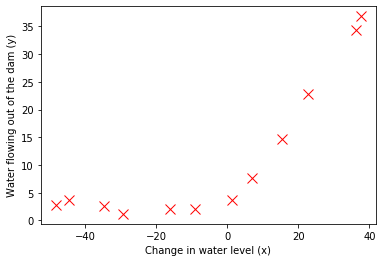

In [10]:
#m = Number of examples
m = X.shape[0]

#Plot training data
plt.plot(X, y, 'rx', markersize = 10, linewidth = 1.5)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

### 1.2 Regularized linear regression cost function

<p>Recall that regularized linear regression has the following cost function:</p>

$$J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})^2 \right) + \frac{\lambda}{2m} \left(\sum_{j=1}^{n} \theta_j^2 \right)$$

<p>where $\lambda$ is a regularization parameter which controls the degree of regularization (thus, help preventing overﬁtting). The regularization term puts a penalty on the overal cost J. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well. Note that you should not regularize the $\theta_0$ term.</p>

<p>You should now complete the code in the function linearRegCostFunction(). Your task is to write a function to calculate the regularized linear regression cost function. If possible, try to vectorize your code and avoid writing loops. When you are ﬁnished, the next part of the script will run your cost function using theta initialized at [1; 1]. You should expect to see an output of 303.993.</p>

In [11]:
theta = np.array([1, 1])

X_ones = np.concatenate([np.ones((m, 1)), X], axis=1)
J, grad = linearRegCostFunction(theta, X_ones, y, 1)

print('Cost at theta = [1,1]:', J)
print('This value should be about 303.993192')

Cost at theta = [1,1]: 303.9931922202643
This value should be about 303.993192


### 1.3 Regularized linear regression gradient

<p>Correspondingly, the partial derivative of regularized linear regression’s cost for $\theta_j$ is deﬁned as</p>

$$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}))-y^{(i)})x^{(i)}_j for j = 0$$
$$\frac{\partial J(\theta)}{\partial \theta_j} = \left (\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}))-y^{(i)})x^{(i)}_j \right ) + \frac{\lambda}{m} \theta_j for j \geq 1$$ 

<p>In linearRegCostFunction(), add code to calculate the gradient, returning it in the variable grad. When you are ﬁnished, the next part of the script will run your gradient function using theta initialized at [1, 1]. You should expect to see a gradient of [-15.30, 598.250].</p>

In [12]:
J, grad = linearRegCostFunction(theta, X_ones, y, 1)

print('Grad at theta = [1,1]:', grad)
print('This value should be about [-15.303016, 598.250744]')

Grad at theta = [1,1]: [-15.30301567 598.25074417]
This value should be about [-15.303016, 598.250744]


### 1.4 Fitting linear regression

<p>Once your cost function and gradient are working correctly, the next part will run the code in trainLinearReg() to compute the optimal values of $\theta$. This training function uses fmincg to optimize the cost function.</p>

<p>In this part, we set regularization parameter $\lambda$ to zero. Because our current implementation of linear regression is trying to ﬁt a 2-dimensional $\theta$, regularization will not be incredibly helpful for a $\theta$ of such low dimension. In the later parts of the exercise, you will be using polynomial regression with regularization.</p>

<p>Finally, the script should also plot the best ﬁt line, resulting in an image similar to Figure 2. The best ﬁt line tells us that the model is not a good ﬁt to the data because the data has a non-linear pattern. While visualizing the best ﬁt as shown is one possible way to debug your learning algorithm, it is not always easy to visualize the data and model. In the next section, you will implement a function to generate learning curves that can help you debug your learning algorithm even if it is not easy to visualize the data.</p>

<img src = "Figure 2.png"/>

In [13]:
#Train linear regression with lambda = 0
X_ones = np.concatenate([np.ones((m, 1)), X], axis=1)
theta = trainLinearReg(X_ones, y, 0)

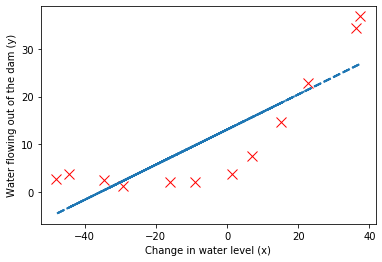

In [14]:
#Plot fit over the data
plt.plot(X, y, 'rx', markersize = 10, linewidth = 1.5)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

plt.plot(X, np.dot(X_ones, theta), '--', linewidth = 2)

plt.show()

## 2. Bias - Variance

<p>An important concept in machine learning is the bias-variance tradeoﬀ. Models with high bias are not complex enough for the data and tend to underﬁt, while models with high variance overﬁt to the training data.</p>

<p>In this part of the exercise, you will plot training and test errors on a learning curve to diagnose bias-variance problems.</p>

### 2.1 Learning Curves

<p>You will now implement code to generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve plots training and cross validation error as a function of training set size. Your job is to ﬁll in learningCurve() so that it returns a vector of errors for the training set and cross validation set.</p>

<p>To plot the learning curve, we need a training and cross validation set error for diﬀerent training set sizes. To obtain diﬀerent <em>training</em> set sizes, you should use diﬀerent subsets of the original training set X. Speciﬁcally, for a training set size of i, you should use the ﬁrst i examples (i.e., X[0:i,:] and y[1:i]).</p>

<p>You can use the trainLinearReg() function to ﬁnd the $\theta$ parameters. Note that the lambda is passed as a parameter to the learningCurve() function. After learning the $\theta$ parameters, you should compute the error on the training and cross validation sets. Recall that the training error for a dataset is deﬁned as</p>

$$J_{train}(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})^2 \right)$$

<p>In particular, note that the training error does not include the regularization term. One way to compute the training error is to use your existing cost function and set $\lambda$ to 0 only when using it to compute the training error and cross validation error. When you are computing the training set error, make sure you compute it on the training subset (i.e., X[1:n,:] and y[1:n]) (instead of the entire training set). However, for the cross validation error, you should compute it over the entire cross validation set. You should store the computed errors in the vectors error train and error val.</p>

<p>When you are ﬁnished, the script will print the learning curves and produce a plot similar to Figure 3.</p>

<img src = "Figure 3.png"/>

<p>In Figure 3, you can observe that <em>both</em> the train error and cross validation error are high when the number of training examples is increased. This reﬂects a <b>high bias</b> problem in the model – the linear regression model is too simple and is unable to ﬁt our dataset well. In the next section, you will implement polynomial regression to ﬁt a better model for this dataset.</p>

In [15]:
lambda_ = 0
X_ones = np.concatenate([np.ones((m, 1)), X], axis=1)

mval = Xval.shape[0]
Xval_ones = np.concatenate([np.ones((mval, 1)), Xval], axis = 1)

error_train, error_val = learningCurve(X_ones, y, Xval_ones, yval, lambda_)

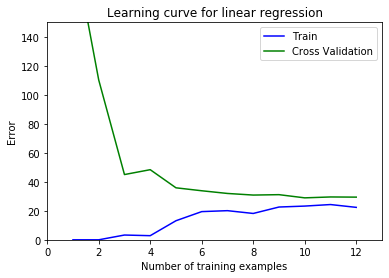

In [16]:
a = np.arange(1,error_train.size + 1)
plt.plot( a, error_train, '-b', label = 'Train' )
plt.plot( a, error_val, '-g', label = 'Cross Validation' )
plt.axis([0, 13, 0, 150])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend()
plt.title('Learning curve for linear regression')
plt.show()

## 3. Polynomial Regression

<p>The problem with our linear model was that it was too simple for the data and resulted in underﬁtting (high bias). In this part of the exercise, you will address this problem by adding more features.</p>

<p>For use polynomial regression, our hypothesis has the form:</p>

$$h_\theta(x) = \theta_0 + \theta_1 * (waterLevel) + \theta_2 * (waterLevel)^2 + ... + \theta_p * (waterLevel)^p = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_p x_p$$

<p>Notice that by defining $x_1 = (waterLevel), x_2 = (waterLevel)^2,..., x_p = (waterLevel)^p$, we obtain a linear regression model where the features are the various powers of the original value (waterLevel).</p>

<p>Now, you will add more features using the higher powers of the existing feature <em>x</em> in the dataset. Your task in this part is to complete the code in polyFeatures() so that the function maps the original training set X of size m x 1 into its higher powers. Speciﬁcally, when a training set X of size m x 1 is passed into the function, the function should return a m x p matrix X_poly, where column 1 holds the original values of X, column 2 holds the values of X.^2, column 3 holds the values of X.^3, and so on. Note that you don’t have to account for the zero-eth power in this function.</p>

<p>Now you have a function that will map features to a higher dimension, this part will apply it to the training set, the test set, and the cross validation set (which you haven’t used yet).</p>

In [17]:
p = 8

#Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)  #Normalize
X_poly = np.concatenate([np.ones((m, 1)), X_poly], axis=1)  #Add ones

#Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, p)
X_poly_test = np.c_[np.ones(X_poly_test.shape[0]), (X_poly_test - mu)/sigma]  #Add ones

X_poly_val = polyFeatures(Xval, p)
X_poly_val = np.c_[np.ones(X_poly_val.shape[0]), (X_poly_val - mu)/sigma]  #Add ones

print('Normalized Training example 1:')
print(X_poly[0,:])

Normalized Training example 1:
[ 1.         -0.3782437  -0.78866232  0.19032872 -0.7375913   0.32025197
 -0.6171516   0.35983501 -0.53109126]


### 3.1 Learning Polynomial Regression

<p>After you have completed polyFeatures(), the script will proceed to train polynomial regression using your linear regression cost function.</p>

<p>Keep in mind that even though we have polynomial terms in our feature vector, we are still solving a linear regression optimization problem. The polynomial terms have simply turned into features that we can use for linear regression. We are using the same cost function and gradient that you wrote for the earlier part of this exercise. </p>

<p>For this part of the exercise, you will be using a polynomial of degree 8. It turns out that if we run the training directly on the projected data, will not work well as the features would be badly scaled (e.g., an example with x = 40 will now have a feature $x_8 = 40^8 = 6.5 X 10^{12}$). Therefore, you will need to use feature normalization.</p>

<p>Before learning the parameters $\theta$ for the polynomial regression, the script will ﬁrst call featureNormalize() and normalize the features of the training set, storing the mu, sigma parameters separately. We have already implemented this function for you and it is the same function from the ﬁrst exercise.</p>

<p>After learning the parameters $\theta$, you should see two plots (Figure 4,5) generated for polynomial regression with $\lambda$ = 0.</p>

<p>From Figure 4, you should see that the polynomial ﬁt is able to follow the datapoints very well - thus, obtaining a low training error. However, the polynomial ﬁt is very complex and even drops oﬀ at the extremes. This is an indicator that the polynomial regression model is overﬁtting the training data and will not generalize well. </p>

<p>To better understand the problems with the unregularized (λ = 0) model, you can see that the learning curve (Figure 5) shows the same eﬀect where the low training error is low, but the cross validation error is high. There is a gap between the training and cross validation errors, indicating a high variance problem.</p>

<img src = "Figure 4.png"/>
<img src = "Figure 5.png"/>

<p>One way to combat the overﬁtting (high-variance) problem is to add regularization to the model. In the next section, you will get to try diﬀerent λ parameters to see how regularization can lead to a better model.</p>

[-80, 80, -60, 60]

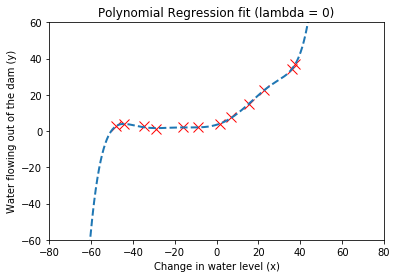

In [18]:
lambda_ = 0
theta = trainLinearReg(X_poly, y, lambda_)

#Plot training data and fit
plt.plot(X, y, 'rx', markersize = 10, linewidth = 1.5)
plotFit(np.amin(X), np.amax(X), mu, sigma, theta, p)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial Regression fit (lambda = {})'.format(lambda_))
plt.axis([-80, 80, -60, 60])

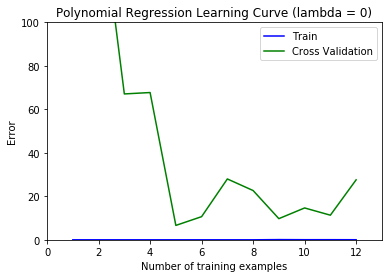

In [19]:
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_)

a = np.arange(1,error_train.size + 1)
plt.plot(a, error_train, '-b', label = 'Train')
plt.plot(a, error_val, '-g', label = 'Cross Validation')
plt.title('Polynomial Regression Learning Curve (lambda = {})'.format(lambda_))
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 100])
plt.legend()

In [20]:
print('Polynomial Regression (lambda = {})'.format(lambda_))
print('# Training Examples \tTrain Error\t\tCross Validation Error')
for i in range(m):
    print('  \t{}\t\t{}\t{}\n'.format(i, error_train[i], error_val[i]))

Polynomial Regression (lambda = 0)
# Training Examples 	Train Error		Cross Validation Error
  	0		9.860761315262648e-32	161.44216831742497

  	1		6.162975822039155e-32	160.7922915011111

  	2		4.61744295772947e-11	67.08492232193544

  	3		1.1879133653657272e-22	67.72684941524093

  	4		3.036111771075477e-16	6.6169871515998775

  	5		4.683427497418469e-14	10.643062982302661

  	6		5.569806689717241e-10	27.986263282789967

  	7		1.224521295897682e-07	22.656931433717183

  	8		0.09358124967384063	9.724977224824048

  	9		0.04896611405372342	14.649609599535456

  	10		0.05313550571333613	11.318482222426207

  	11		0.03649944223100441	27.57659737414161



### 3.2 Optional (ungraded) exercise: Adjusting the regularization parameter

<p>In this section, you will get to observe how the regularization parameter aﬀects the bias-variance of regularized polynomial regression. You should now modify the the lambda parameter in the script and try λ = 1,100. For each of these values, the script should generate a polynomial ﬁt to the data and also a learning curve.</p>

<p>For λ = 1, you should see a polynomial ﬁt that follows the data trend well (Figure 6) and a learning curve (Figure 7) showing that both the cross validation and training error converge to a relatively low value. This shows the λ = 1 regularized polynomial regression model does not have the highbias or high-variance problems. In eﬀect, it achieves a good trade-oﬀ between bias and variance.</p>

<p>For λ = 100, you should see a polynomial ﬁt (Figure 8) that does not follow the data well. In this case, there is too much regularization and the model is unable to ﬁt the training data.</p>

<img src = "Figure 6.png"/>
<img src = "Figure 7.png"/>
<img src = "Figure 8.png"/>

[-80, 80, 0, 160]

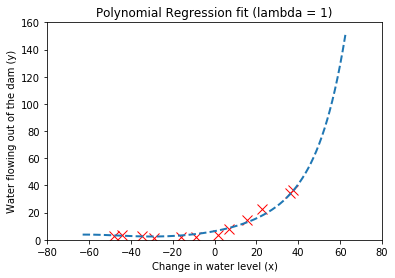

In [21]:
#When lambda_ = 1

lambda_ = 1
theta = trainLinearReg(X_poly, y, lambda_)

#Plot training data and fit
plt.plot(X, y, 'rx', markersize = 10, linewidth = 1.5)
plotFit(np.amin(X), np.amax(X), mu, sigma, theta, p)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial Regression fit (lambda = {})'.format(lambda_))
plt.axis([-80, 80, 0, 160])

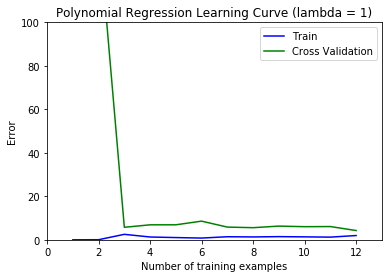

In [22]:
#When lambda_ = 1

error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_)

a = np.arange(1,error_train.size + 1)
plt.plot(a, error_train, '-b', label = 'Train')
plt.plot(a, error_val, '-g', label = 'Cross Validation')
plt.title('Polynomial Regression Learning Curve (lambda = {})'.format(lambda_))
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 100])
plt.legend()

[-80, 80, -10, 60]

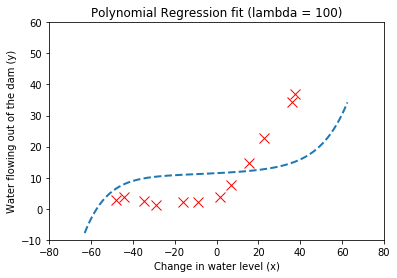

In [23]:
#When lambda_ = 100

lambda_ = 100
theta = trainLinearReg(X_poly, y, lambda_)

#Plot training data and fit
plt.plot(X, y, 'rx', markersize = 10, linewidth = 1.5)
plotFit(np.amin(X), np.amax(X), mu, sigma, theta, p)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial Regression fit (lambda = {})'.format(lambda_))
plt.axis([-80, 80, -10, 60])

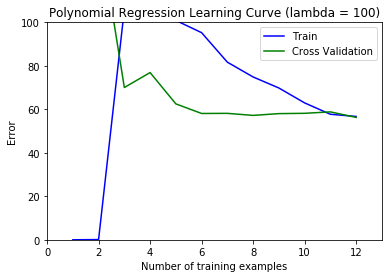

In [24]:
#When lambda_ = 100

error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_)

a = np.arange(1,error_train.size + 1)
plt.plot(a, error_train, '-b', label = 'Train')
plt.plot(a, error_val, '-g', label = 'Cross Validation')
plt.title('Polynomial Regression Learning Curve (lambda = {})'.format(lambda_))
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 100])
plt.legend()

### 3.3 Selecting λ using a cross validation set

<p>From the previous parts of the exercise, you observed that the value of λ can signiﬁcantly aﬀect the results of regularized polynomial regression on the training and cross validation set. In particular, a model without regularization (λ = 0) ﬁts the training set well, but does not generalize. Conversely, a model with too much regularization (λ = 100) does not ﬁt the training set and testing set well. A good choice of λ (e.g., λ = 1) can provide a good ﬁt to the data. </p>

<p>In this section, you will implement an automated method to select the λ parameter. Concretely, you will use a cross validation set to evaluate how good each λ value is. After selecting the best λ value using the cross validation set, we can then evaluate the model on the test set to estimate how well the model will perform on actual unseen data.</p>

<p>Your task is to complete the code in validationCurve(). Speciﬁcally, you should should use the trainLinearReg() function to train the model using diﬀerent values of λ and compute the training error and cross validation error. You should try λ in the following range: {0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10}.</p>

<img src = "Figure 9.png"/>

<p>After you have completed the code, the next part will run your function can plot a cross validation curve of error v.s. λ that allows you select which λ parameter to use. You should see a plot similar to Figure 9. In this ﬁgure, we can see that the best value of λ is around 3. Due to randomness in the training and validation splits of the dataset, the cross validation error can sometimes be lower than the training error.</p>

Text(0, 0.5, 'Error')

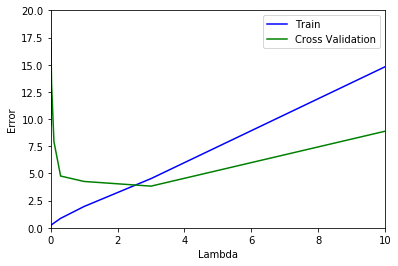

In [25]:
lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

plt.plot(lambda_vec, error_train, '-b', label = 'Train')
plt.plot(lambda_vec, error_val, '-g', label = 'Cross Validation')
plt.axis([0, np.amax(lambda_vec), 0, 20])
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('Error')

In [26]:
print('Lambda\tTrain Error\tValidation Error')
for i in range(lambda_vec.size):
    print(' {}\t{}\t{}\n'.format(lambda_vec[i], error_train[i], error_val[i]))
    
    

Lambda	Train Error	Validation Error
 0.0	[0.03649944]	[27.57659737]

 0.001	[0.1081896]	[9.42391895]

 0.003	[0.16680993]	[15.9423509]

 0.01	[0.21797469]	[17.15238275]

 0.03	[0.27514587]	[13.21717503]

 0.1	[0.43864334]	[7.92703408]

 0.3	[0.86816255]	[4.76079896]

 1.0	[1.95869484]	[4.26335861]

 3.0	[4.52510481]	[3.83217638]

 10.0	[14.82580826]	[8.88972473]



### 3.4 Optional (ungraded) exercise: Computing test set error

<p>In the previous part of the exercise, you implemented code to compute the cross validation error for various values of the regularization parameter λ. However, to get a better indication of the model’s performance in the real world, it is important to evaluate the “ﬁnal” model on a test set that was not used in any part of training (that is, it was neither used to select the λ parameters, nor to learn the model parameters θ).</p>

<p>For this optional (ungraded) exercise, you should compute the test error using the best value of λ you found. In our cross validation, we obtained a test error of 3.8599 for λ = 3.</p>

Test error: 9.522050043642835


[-80, 80, -10, 60]

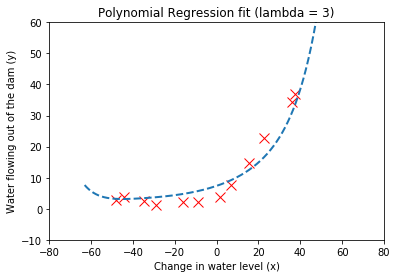

In [27]:
#When lambda_ = 3

lambda_ = 3
theta = trainLinearReg(X_poly, y, lambda_)

J_poly_test, __ = linearRegCostFunction(theta, X_poly_test, ytest, lambda_)
print('Test error:', J_poly_test)

#Plot training data and fit
plt.plot(X, y, 'rx', markersize = 10, linewidth = 1.5)
plotFit(np.amin(X), np.amax(X), mu, sigma, theta, p)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial Regression fit (lambda = {})'.format(lambda_))
plt.axis([-80, 80, -10, 60])

### 3.5 Optional (ungraded) exercise: Plotting learning curves with randomly selected examples

<p>In practice, especially for small training sets, when you plot learning curves to debug your algorithms, it is often helpful to average across multiple sets of randomly selected examples to determine the training error and cross validation error.</p>
<p>Concretely, to determine the training error and cross validation error for i examples, you should ﬁrst randomly select i examples from the training set and i examples from the cross validation set. You will then learn the parameters θ using the randomly chosen training set and evaluate the parameters θ on the randomly chosen training set and cross validation set. The above steps should then be repeated multiple times (say 50) and the averaged error should be used to determine the training error and cross validation error for i examples.</p>
<p>For this optional (ungraded) exercise, you should implement the above strategy for computing the learning curves. For reference, ﬁgure 10 shows the learning curve we obtained for polynomial regression with λ = 0.01. Your ﬁgure may diﬀer slightly due to the random selection of examples.</p>

<img src = "Figure 10.png"/>

[-80, 80, -10, 60]

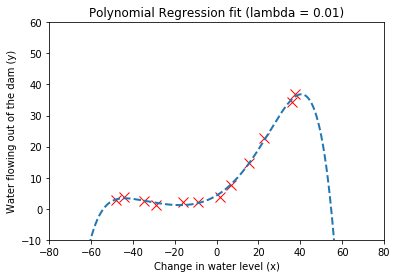

In [28]:
#When lambda_ = 0.01

lambda_ = 0.01
theta = trainLinearReg(X_poly, y, lambda_)

#Plot training data and fit
plt.plot(X, y, 'rx', markersize = 10, linewidth = 1.5)
plotFit(np.amin(X), np.amax(X), mu, sigma, theta, p)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial Regression fit (lambda = {})'.format(lambda_))
plt.axis([-80, 80, -10, 60])

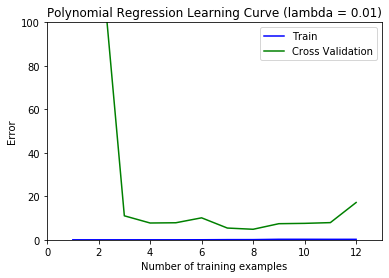

In [29]:
#When lambda_ = 100

error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_)

a = np.arange(1,error_train.size + 1)
plt.plot(a, error_train, '-b', label = 'Train')
plt.plot(a, error_val, '-g', label = 'Cross Validation')
plt.title('Polynomial Regression Learning Curve (lambda = {})'.format(lambda_))
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 100])
plt.legend()